In [7]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy
import numpy as np

In [8]:
db = sqlalchemy.engine.url.URL(drivername='mysql',
                            host='127.0.0.1',
                            database='sherman_1',
                            query={'read_default_file': '~/.my.cnf', 'charset':'utf8'})
engine = sqlalchemy.create_engine(db)

In [9]:
df = pd.read_sql('''
    SELECT * FROM sherman_1.screen;
''' ,engine)

In [10]:
df

,_id,timestamp,device_id,screen_status
0,4967,1.644532e+12,a4c1d675-6571-4722-a2de-bff72248bab8,1
1,4968,1.644532e+12,a4c1d675-6571-4722-a2de-bff72248bab8,3
2,4969,1.644532e+12,a4c1d675-6571-4722-a2de-bff72248bab8,1
3,4970,1.644532e+12,a4c1d675-6571-4722-a2de-bff72248bab8,3
4,33138,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,3
...,...,...,...,...
257841,290975,1.673474e+12,890fa6c5-0126-4953-8bb8-808dffcb55c8,3
257842,290976,1.673473e+12,41646f47-46d6-4ea7-90fd-0b6afaea3d64,2
257843,290977,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,2
257844,290978,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,3


In [11]:
def get_on_time(df):
    uniq_device_id = list(set(df['device_id'].tolist()))
    df_output = pd.DataFrame()
    for device_id in uniq_device_id:
        df_target = df[df['device_id']==device_id]
        df_target = df_target.sort_values(by = 'timestamp', ascending = False)
        past_timestamp = df_target['timestamp'].tolist()
        past_timestamp = past_timestamp[1:]+[None]
        past_status = df_target['screen_status'].tolist()
        past_status = past_status[1:]+[None]
        df_target['past_timestamp'] = past_timestamp
        df_target['past_status'] = past_status
        df_target = df_target[(df_target['screen_status']==2)&(df_target['past_status']==3)]
        if df_target.shape[0]>0:
            df_target['screen_on_time'] = df_target.apply(lambda x: (x['timestamp']-x['past_timestamp'])/1000, axis = 1)
            df_target = df_target[['device_id','timestamp','screen_on_time']]
            df_output = pd.concat([df_output, df_target], ignore_index=True)
    
    return df_output

In [12]:
df_less = get_on_time(df)
df_less

,device_id,timestamp,screen_on_time
0,dff9a20d-f314-4901-8adc-fa91b6e2c5b8,1.673471e+12,59.650
1,dff9a20d-f314-4901-8adc-fa91b6e2c5b8,1.673470e+12,611.830
2,dff9a20d-f314-4901-8adc-fa91b6e2c5b8,1.673470e+12,63.230
3,dff9a20d-f314-4901-8adc-fa91b6e2c5b8,1.673470e+12,3.649
4,dff9a20d-f314-4901-8adc-fa91b6e2c5b8,1.673470e+12,503.364
...,...,...,...
126588,e8710240-dd8b-4792-a940-e4cf5c1760e4,1.670543e+12,89.905
126589,e8710240-dd8b-4792-a940-e4cf5c1760e4,1.670543e+12,208.863
126590,e8710240-dd8b-4792-a940-e4cf5c1760e4,1.670543e+12,1374.980
126591,e8710240-dd8b-4792-a940-e4cf5c1760e4,1.670533e+12,14.144


In [13]:
df_less['date'] = pd.to_datetime(df_less['timestamp'],unit='ms').dt.date

In [14]:
df_less = df_less[['device_id','date','screen_on_time']]

In [15]:
df_output = df_less.groupby(['device_id','date']).agg(screen_on_time = ('screen_on_time', np.sum),
                                                      screen_on_freq = ('screen_on_time',len)
                                                     )
df_output = df_output.reset_index()
df_output['screen_on_freq'] = df_output['screen_on_freq'].apply(lambda x: int(x))
df_output

,device_id,date,screen_on_freq,screen_on_time
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,11,1831.390
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,40,5478.451
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,41,7987.292
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,49,9316.163
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,58,13422.876
...,...,...,...,...
3013,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,48,11024.756
3014,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,63,21846.925
3015,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,104,35124.968
3016,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,25,4210.308


In [16]:
df_output.to_csv("screen_cleaned.csv", index = False)

# filter 1-28

In [17]:
def find_first_day(device_id, df_cleaned):
    df_target = df_cleaned[df_cleaned['device_id']==device_id]
    return min(df_target['date'])

In [18]:
def get_1_to_28(df_cleaned):
    first_day = {device_id:find_first_day(device_id, df_cleaned) 
                 for device_id in set(df_cleaned['device_id'].tolist())
                if find_first_day(device_id, df_cleaned)>=datetime.date(year=2022,month=11,day=11)}
    df_cleaned = df_cleaned[df_cleaned['device_id'].isin(first_day)]
    df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_cleaned = df_cleaned[df_cleaned['day']<=28]
    return df_cleaned

In [19]:
df_cleaned_1_28 = get_1_to_28(df_output)
df_cleaned_1_28

/home/jch0/.conda/envs/jch0/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,device_id,date,screen_on_freq,screen_on_time,day
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,11,1831.390,1
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,40,5478.451,2
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,41,7987.292,3
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,49,9316.163,4
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,58,13422.876,5
...,...,...,...,...,...
3013,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,48,11024.756,23
3014,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,63,21846.925,24
3015,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,104,35124.968,25
3016,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,25,4210.308,26


# lineplot

In [92]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot[['screen_on_freq','screen_on_time','day']]
df_plot = df_plot.groupby('day').mean()
df_plot = df_plot.reset_index()


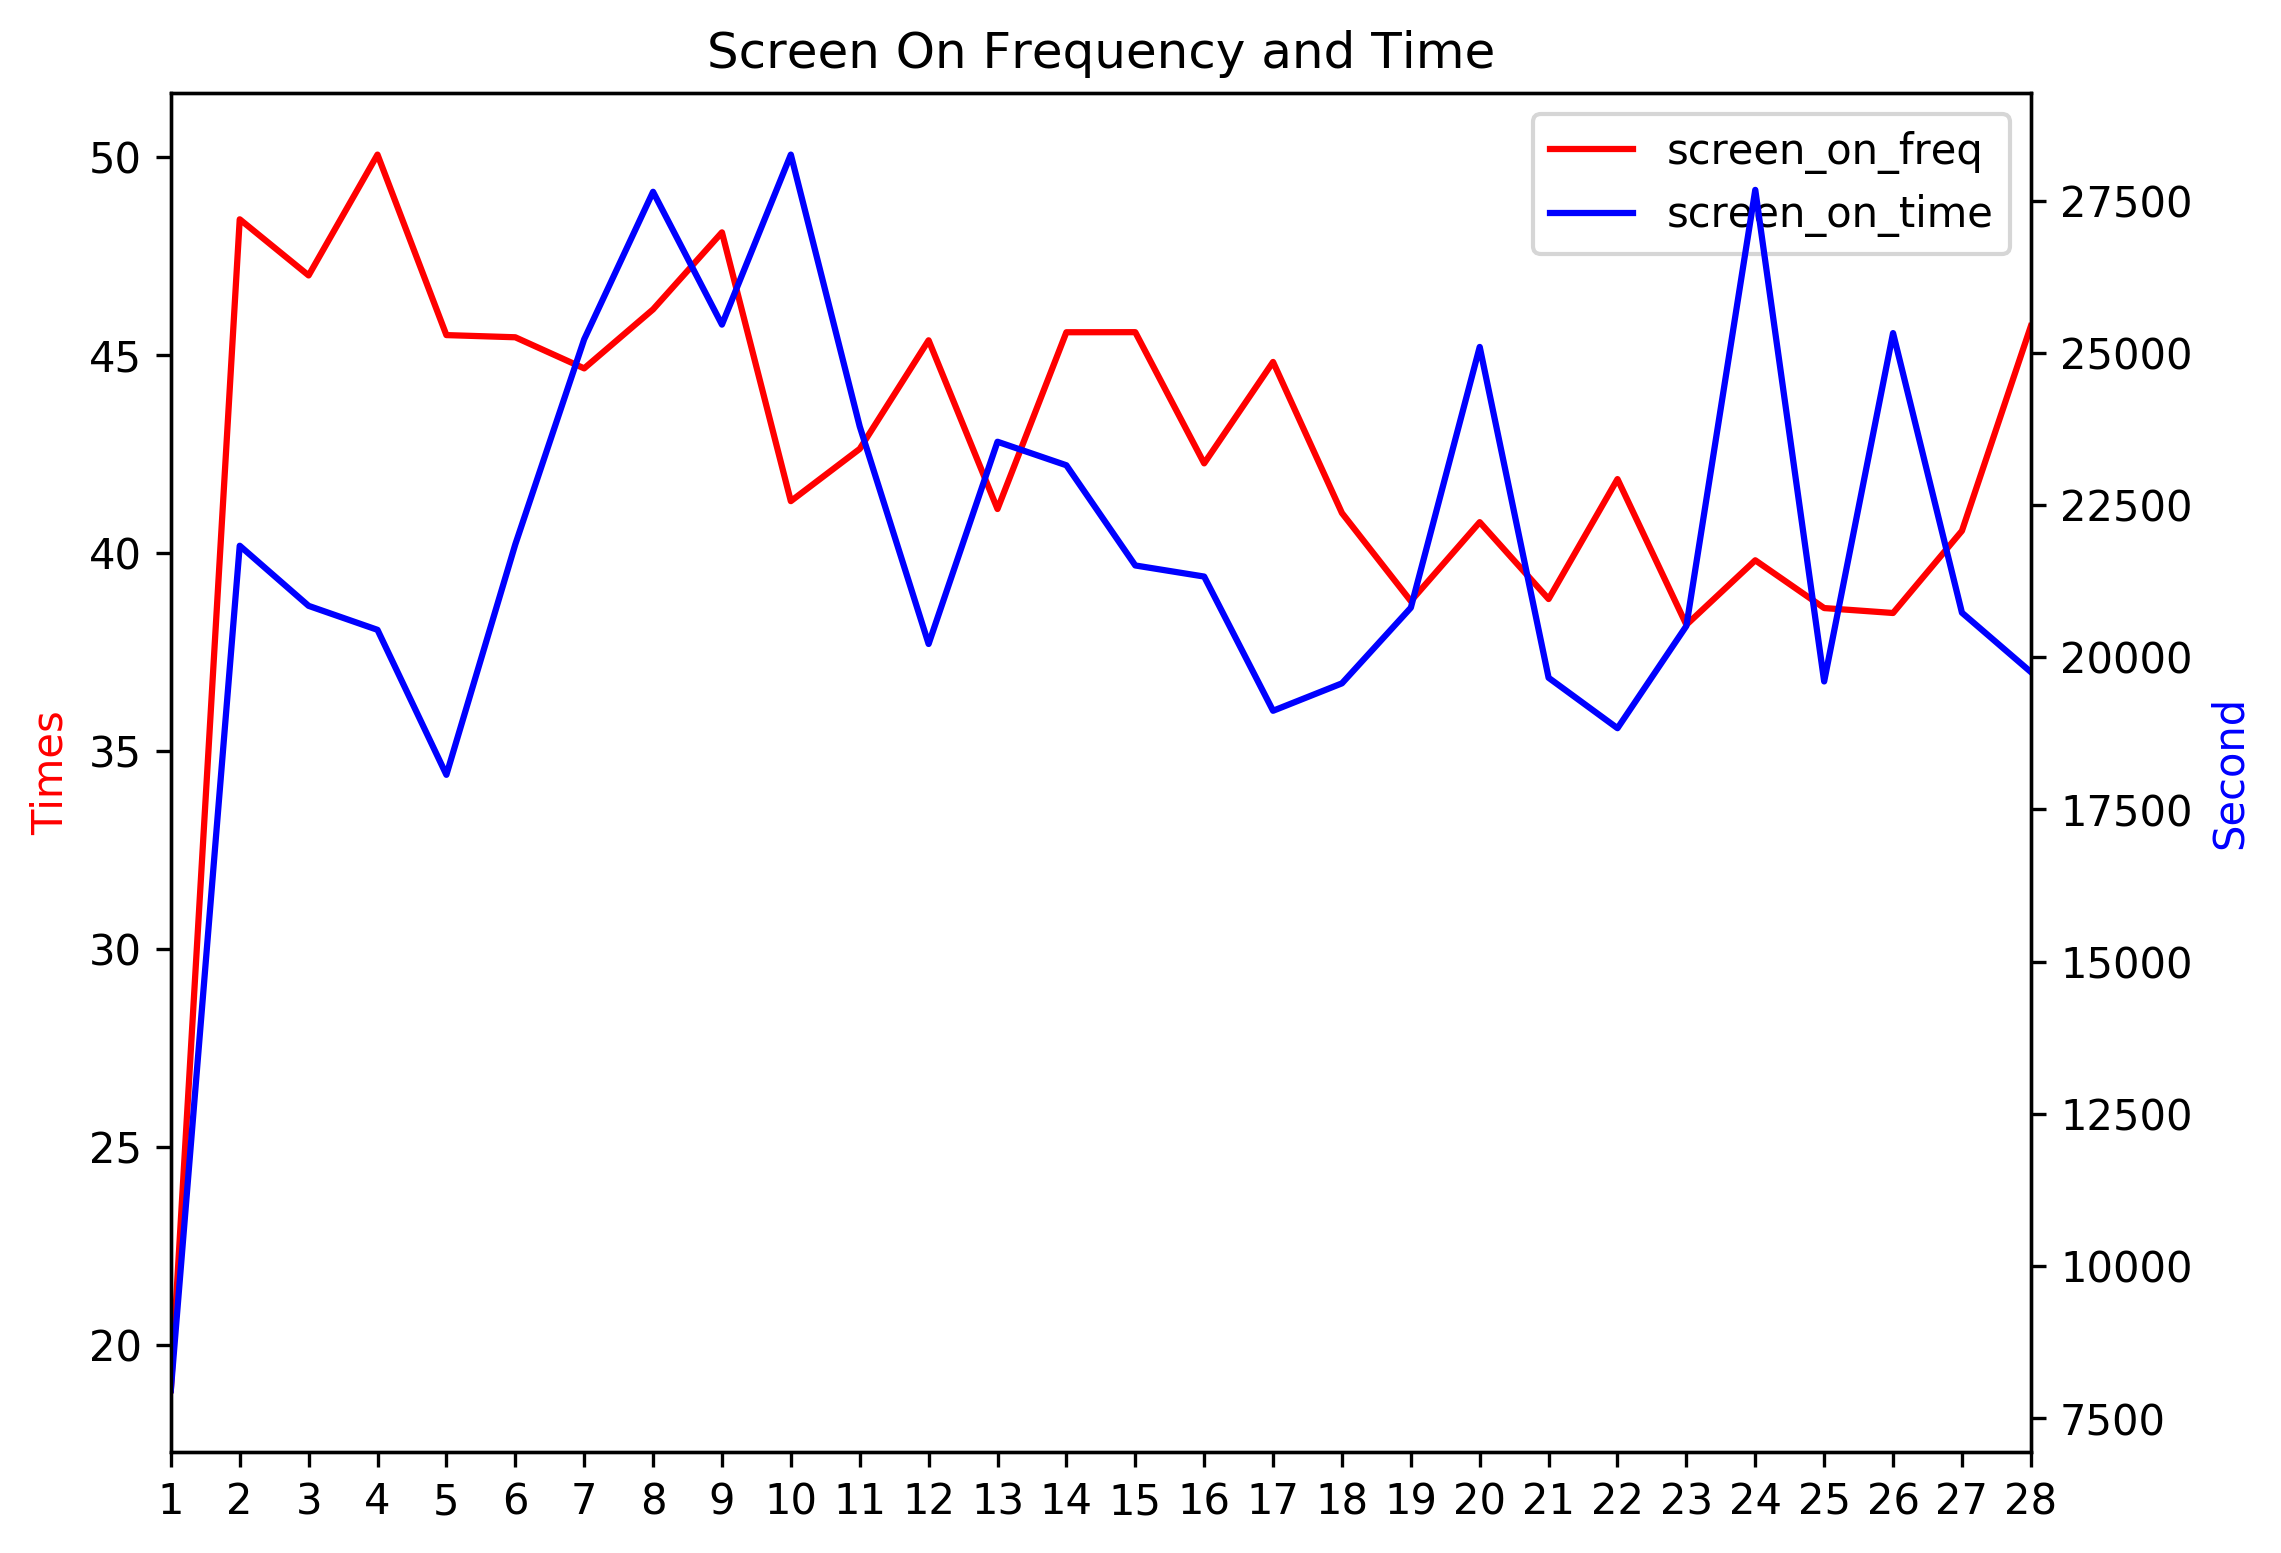

In [93]:
fig = plt.figure(figsize=(8, 6), dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
x = [i+1 for i in range(28)]
y1 = df_plot['screen_on_freq'].tolist()
y2 = df_plot['screen_on_time'].tolist()
ln1 = ax1.plot(x,y1,label = 'screen_on_freq', color = 'red')
ln2 = ax2.plot(x,y2,label = 'screen_on_time', color = 'blue')



plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Screen On Frequency and Time")
plt.xlabel("Days After Join")
ax1.set_ylabel('Times', color = 'red')
ax2.set_ylabel('Second', color = 'blue')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()

# group plot 

In [20]:
df_id = pd.read_csv("/data/meditation/majid/tables/id.csv")
df_id = df_id.drop_duplicates('study_id')
df_id = df_id.drop('id', axis = 1)
df_id.columns = ['device_id','Study ID']

df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv', skiprows=[1,2])[['Study ID','Group']]
df_group = df_id.merge(df_group, on = 'Study ID', how = 'left')
df_group

,device_id,Study ID,Group
0,4a23c5dc-9a50-4d46-a12d-dd94ee98270f,8415477,Experimental Condition
1,f3845ba4-8702-42cf-a14f-051c46f66b61,15027959,Active Control
2,ae02314b-a607-41b9-9507-28ffa1babed7,73386307,Active Control
3,b460f89e-fd76-46ff-a960-989d74fcb66a,87785016,Active Control
4,e5048fab-dc20-4d99-8cea-220a5a2750e0,14851895,Passive Control
...,...,...,...
64,780c9b18-72d3-4714-858d-3c91b3719155,21788465,Active Control
65,a1118578-bbb4-47ef-b784-7d5bd09ad8b5,7389236,Passive Control
66,00e17b8a-4b0f-4230-bd26-3df2853e8916,69546645,Experimental Condition
67,029e57cb-fa0d-479d-abd2-9cb5745f219d,72690342,Passive Control


In [21]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['screen_on_freq','screen_on_time','day','Group']]
df_plot = df_plot.groupby(['Group','day']).mean()
df_plot = df_plot.reset_index()
df_plot

,Group,day,screen_on_freq,screen_on_time
0,Active Control,1,18.869565,10810.975565
1,Active Control,2,51.521739,19069.802696
2,Active Control,3,52.434783,18047.046130
3,Active Control,4,55.304348,19250.152304
4,Active Control,5,47.500000,18213.216591
...,...,...,...,...
79,Passive Control,24,40.000000,48635.977588
80,Passive Control,25,42.125000,25029.385313
81,Passive Control,26,41.588235,36790.099765
82,Passive Control,27,45.294118,28678.762471


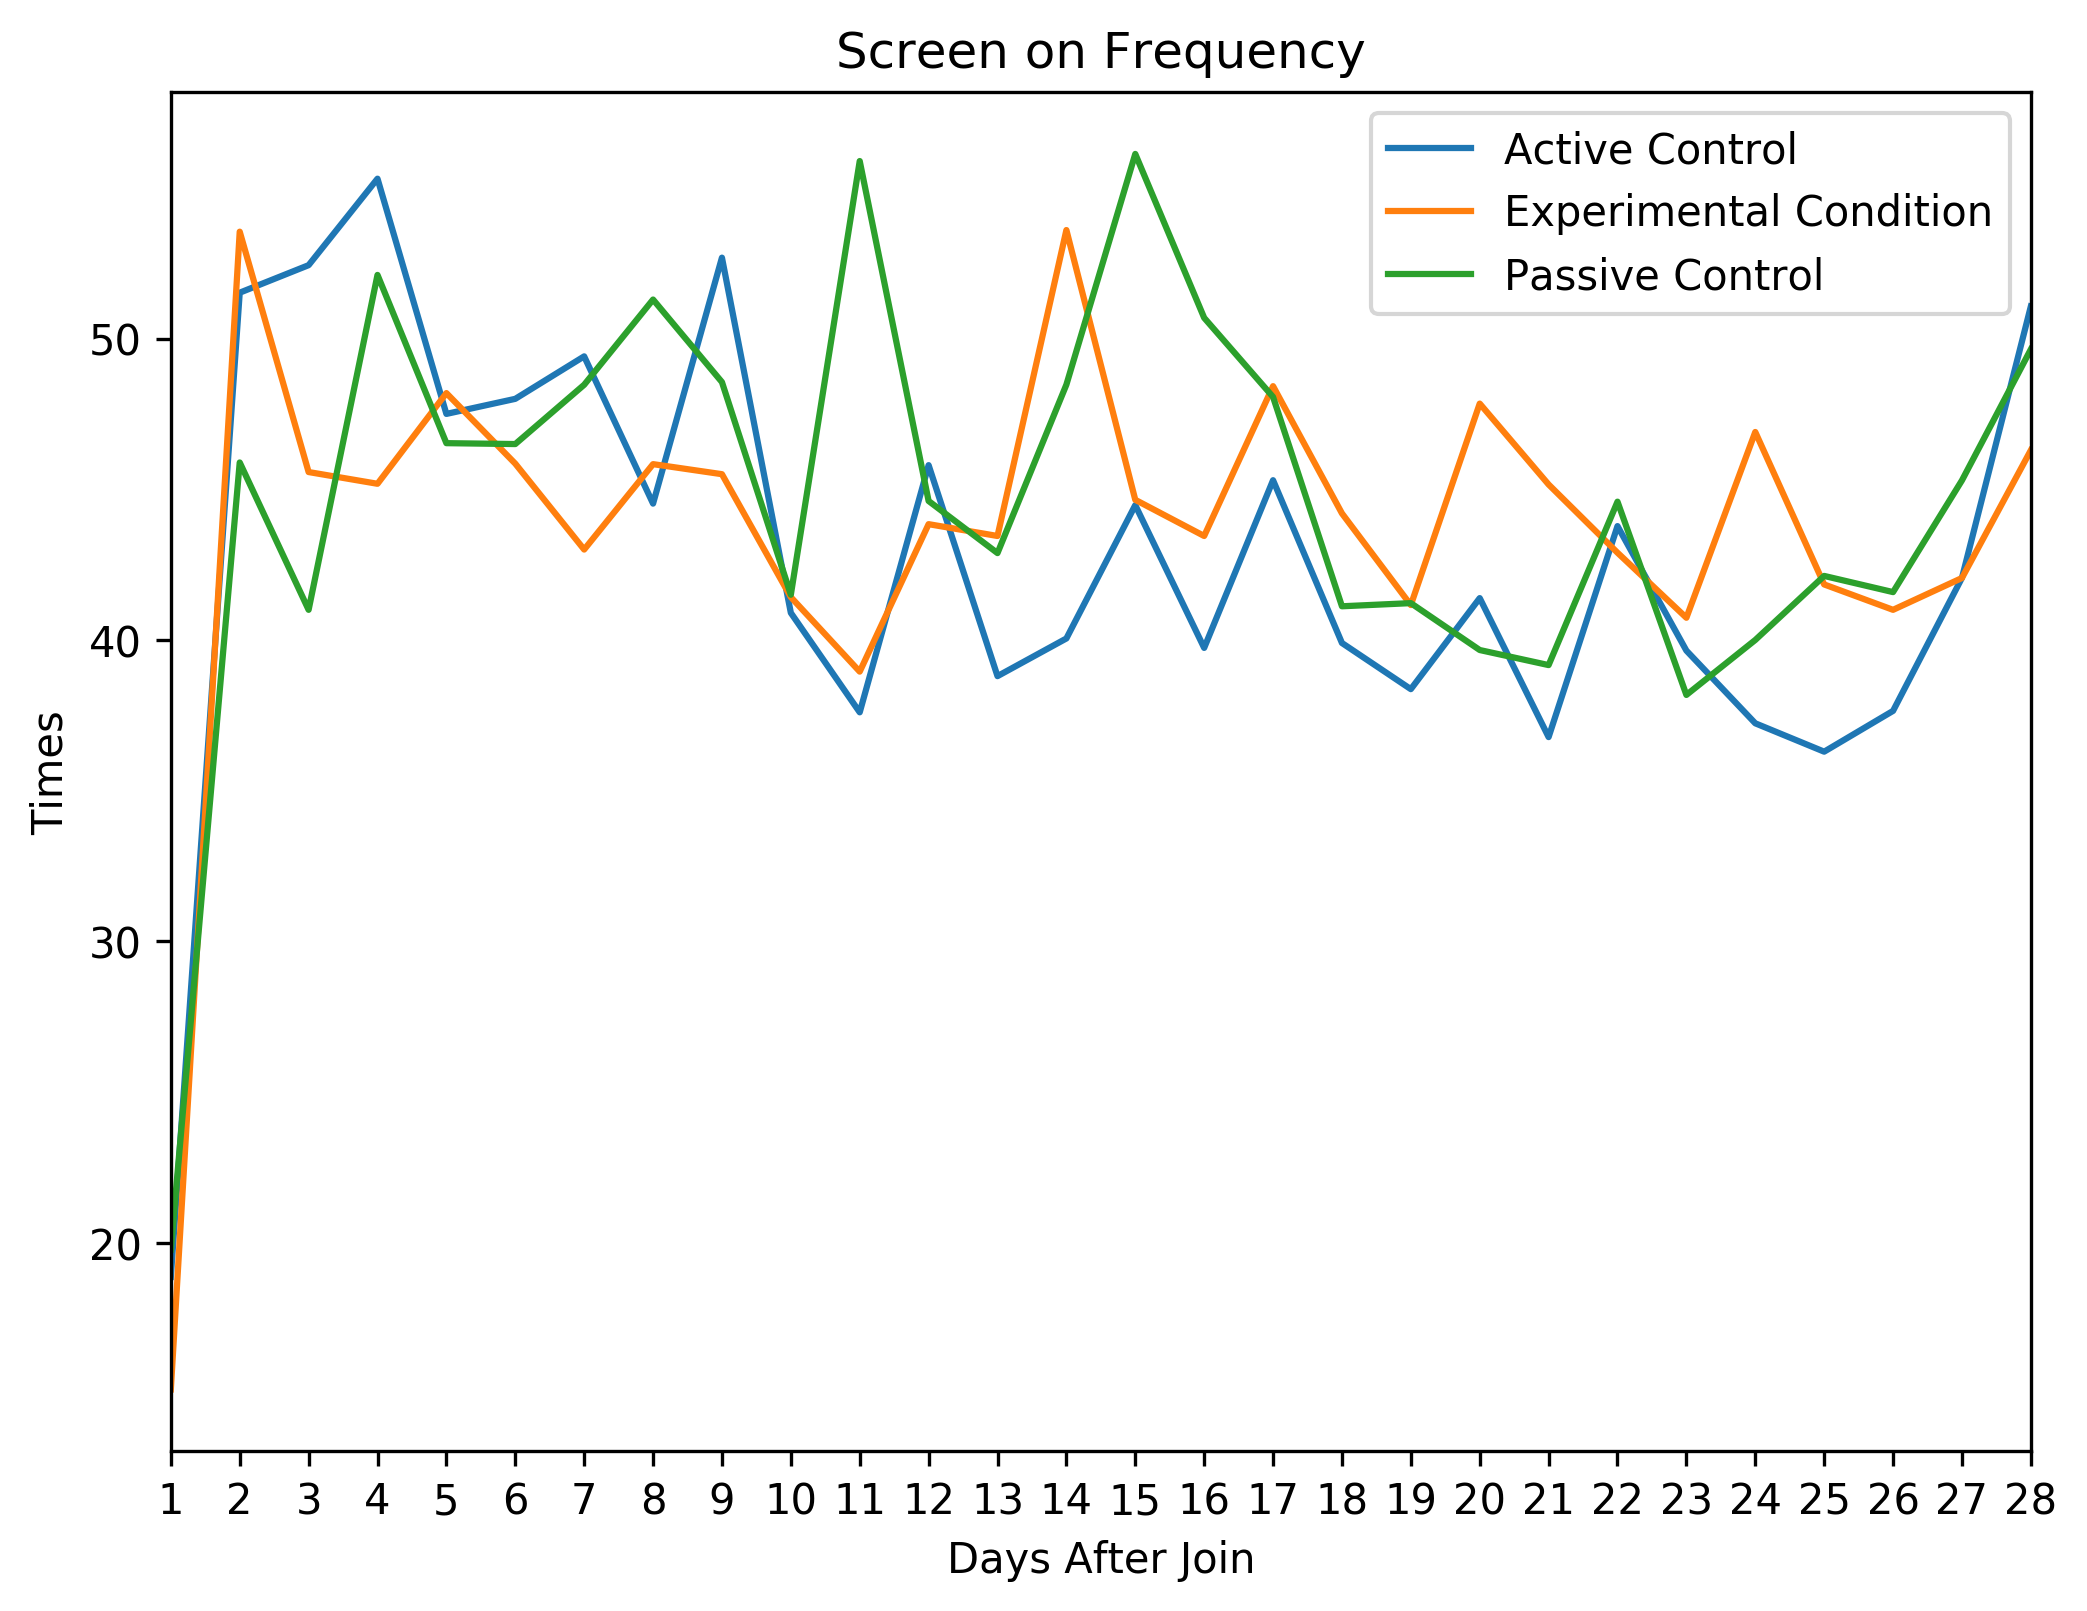

In [22]:
plt.figure(figsize=(8, 6), dpi=300)
for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
    df_target = df_plot[df_plot['Group']==group]
    x = [i+1 for i in range(28)]
    y = df_target["screen_on_freq"].tolist()
    plt.plot(x,y,label = group)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Screen on Frequency")
plt.xlabel("Days After Join")
plt.ylabel('Times')
plt.legend()
plt.show()

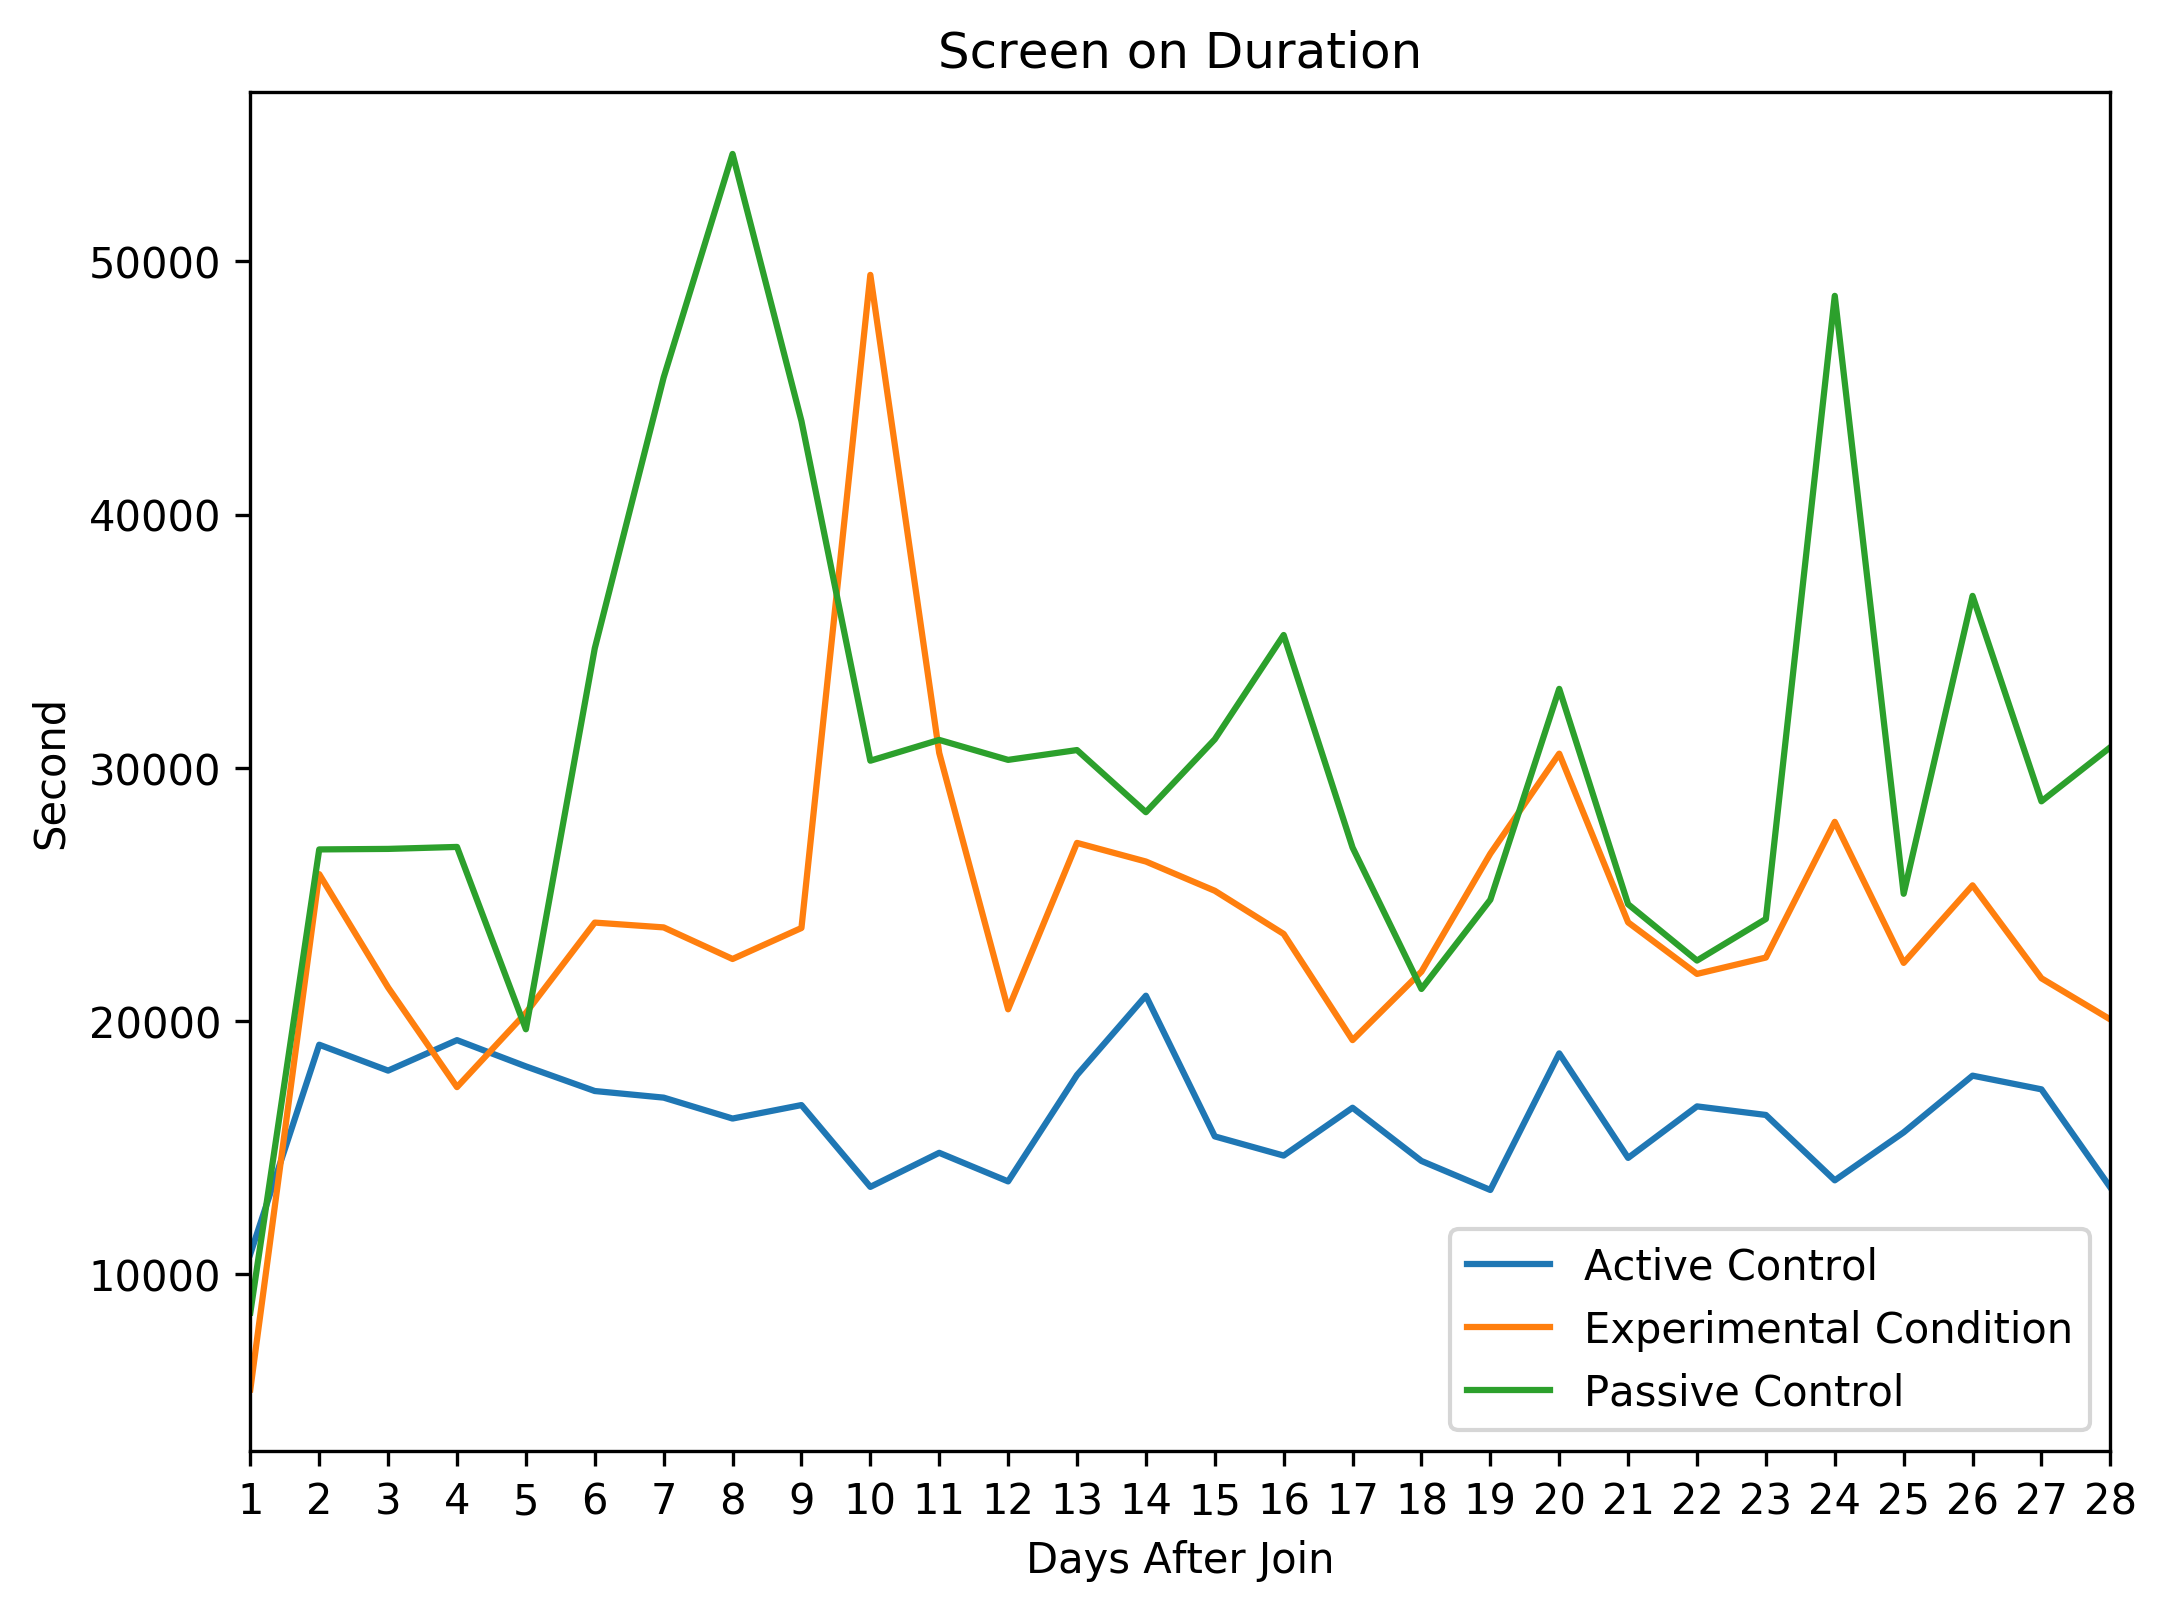

In [23]:
plt.figure(figsize=(8, 6), dpi=300)
for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
    df_target = df_plot[df_plot['Group']==group]
    x = [i+1 for i in range(28)]
    y = df_target["screen_on_time"].tolist()
    plt.plot(x,y,label = group)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Screen on Duration")
plt.xlabel("Days After Join")
plt.ylabel('Second')
plt.legend()
plt.show()